# Deep Learning - Research Project

## We'll build an image classification model using PyTorch. In this Python notebook we use a custom dataset, define a convolutional neural network (CNN) architecture, train the model, and evaluate its performance.

### Importing Required Libraries

In [10]:
import os
import time
import random

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.optim import Adam

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Access dataset directory

In [12]:
dataset_dir = Path(os.getcwd()+"/Dataset/Fruit_Veg_Diseases")

### Function to remove hidden folders and files 

In [13]:
def listdir_nohidden(path):
    visible_files = []
    for file in os.listdir(path):
        if not file.startswith('.'):
            visible_files.append(file)
    return visible_files

### Total number of non hidden sub-directories & files

In [14]:
len(listdir_nohidden(dataset_dir))

28

### Function to calculate data for each class in dataset directory

In [15]:
def count_data_per_class(path):
    classes = sorted(listdir_nohidden(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        class_counts[cls] = len(listdir_nohidden(class_path))
    return class_counts

### Total data of each class

In [16]:
train_class_counts = count_data_per_class(dataset_dir)

In [17]:
train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])

### Total classes in the dataset

In [18]:
print(f"Total Classes in the Dataset: {len(train_class_counts)} classes")

Total Classes in the Dataset: 28 classes


### Total data for all classes in the dataset

In [19]:
print(f"Total Data in the Dataset: {sum(train_counts_df.sum())} images")

Total Data in the Dataset: 29291 images


### Visualize data distribution for each class in dataset

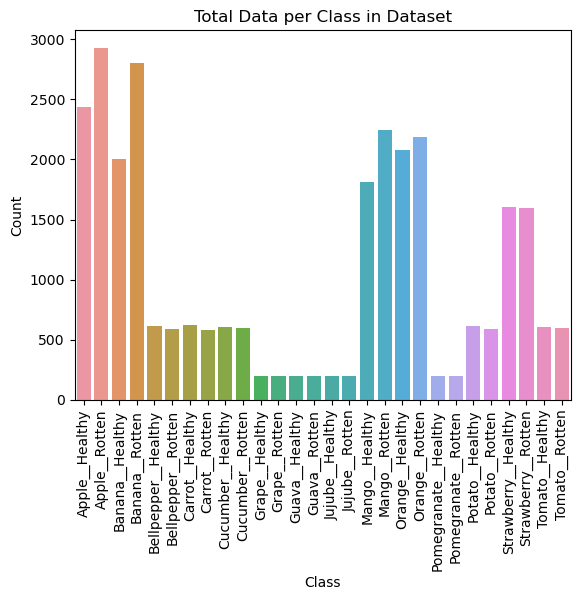

In [20]:
sns.barplot(data=train_counts_df, x=train_counts_df.index, y="Count")
pyplt.title("Total Data per Class in Dataset")
pyplt.xlabel("Class")
pyplt.ylabel("Count")
pyplt.xticks(rotation=90)
pyplt.show()

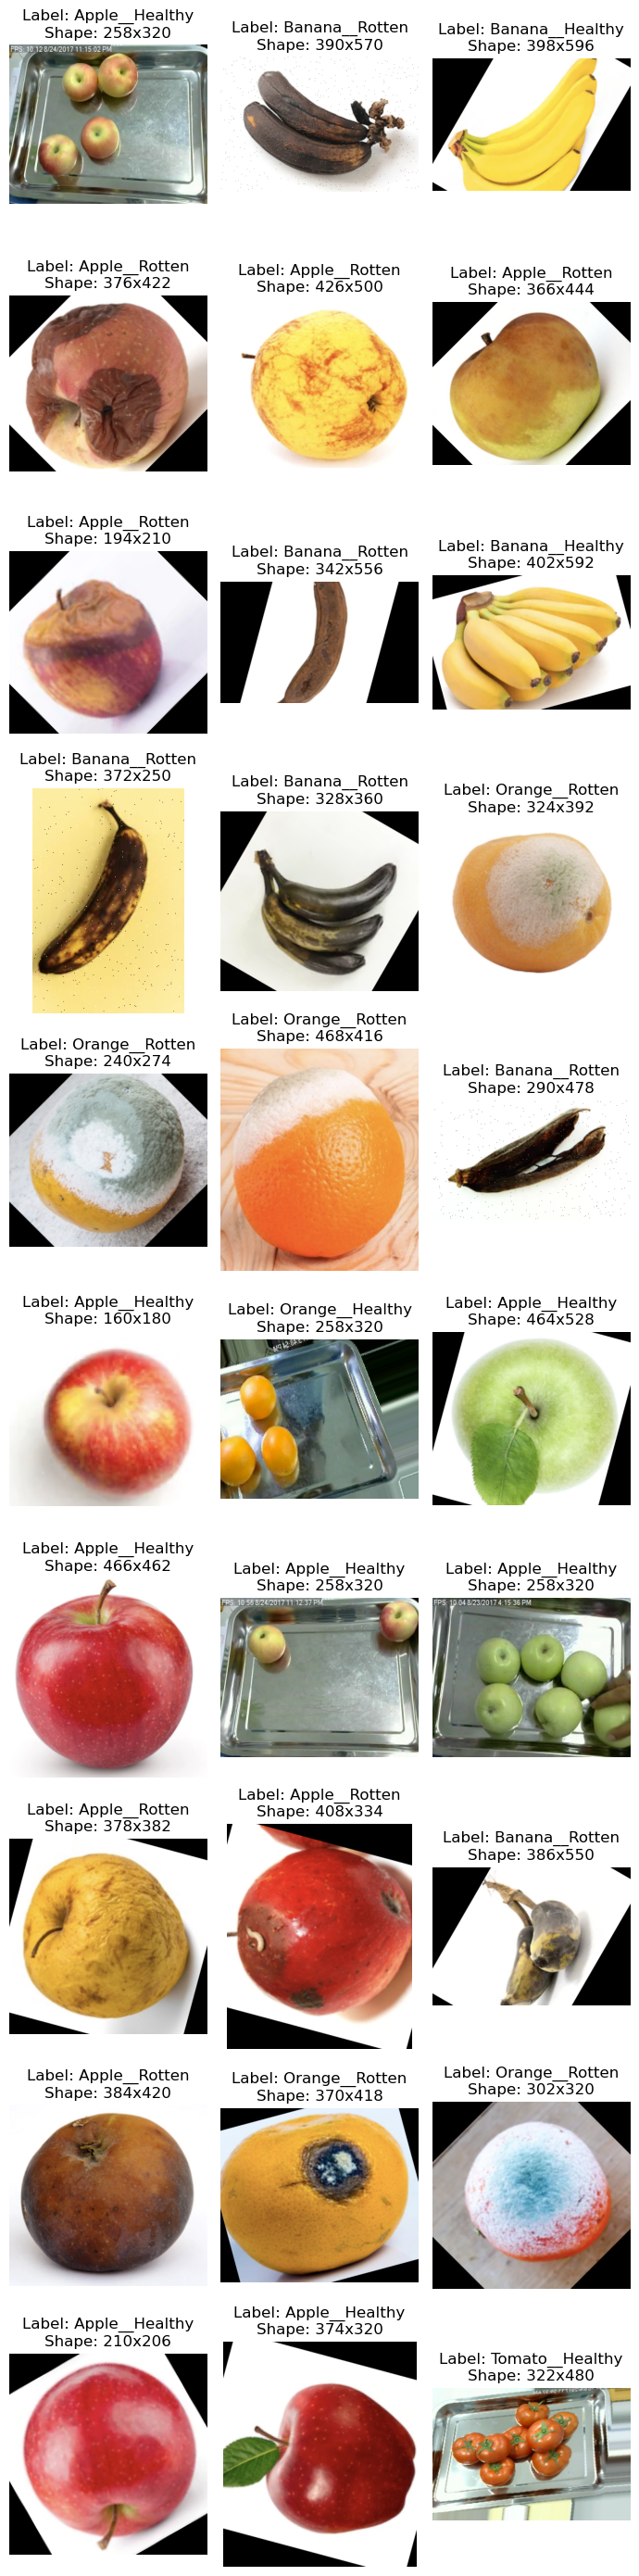

In [21]:
image_path_list = list(dataset_dir.glob("*/*.png"))

random_image_paths = random.sample(image_path_list, 30)

fig, axes = pyplt.subplots(nrows=10, ncols=3,figsize=(7, 28))

for i, ax in enumerate(axes.flat):
    random_image_path = random_image_paths[i] # get image path
    image_class = random_image_path.parent.stem # get image class from path name as label
    image = Image.open(random_image_path) # open image
    ax.imshow(image) # display image on subplot
    
    # add label and shape of image
    ax.set_title(f"Label: {image_class}\nShape: {image.height}x{image.width}")
    ax.axis("off")

pyplt.tight_layout()
pyplt.show()

### Custom Dataset Class which is responsible for loading and preprocessing the images from the dataset.

In [22]:
class Fruit_Veg_Disease_Dataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(listdir_nohidden(root_dir))
        self.image_paths = []
        self.labels = []
        
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            image_names = listdir_nohidden(class_dir)
            random.shuffle(image_names)
                
            if split == 'train':
                image_names = image_names[:int(0.6 * len(image_names))]
            elif split == 'val':
                image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
            else:
                image_names = image_names[int(0.8 * len(image_names)):]
            
            for image_name in image_names:
                self.image_paths.append(os.path.join(class_dir, image_name))
                self.labels.append(i)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

### Define `Convolutional Neural Network` (CNN) Model Architecture that inherits from PyTorch's `nn.Module` class. This model architecture consists of convolutional, pooling, and fully connected layers.

In [23]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Defining hyperparameters, These hyperparameters can be adjusted based on the requirements and available computational resources

In [24]:
batch_size = 32            # Number of samples per batch during training and evaluation.
num_epochs = 5             # Number of epochs to train the model.
learning_rate = 0.001      # Learning rate for the optimizer.

### Using `transforms.Compose` for image transformations, which is to ensure that the images are preprocessed consistently before being fed into the model.

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Following code allows us to load the dataset images with the specified transformations for each split.
#### Train (60%), Validate (20%) & Test (20%)

In [26]:
train_dataset = Fruit_Veg_Disease_Dataset(dataset_dir, split='train', transform=transform)
val_dataset = Fruit_Veg_Disease_Dataset(dataset_dir, split='val', transform=transform)
test_dataset = Fruit_Veg_Disease_Dataset(dataset_dir, split='test', transform=transform)

### Using `DataLoader` to create data loaders for each dataset :
#### These data loaders provide an efficient way to iterate over the dataset during training and evaluation, handling batching and shuffling as specified.

### Dataloader for Custom CNN

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model Initialization
#### Create an instance of the CNN model, passing the `num_classes` parameter. The `num_classes` is determined by the number of unique classes in the dataset. This ensures that the model's output layer has the correct number of units corresponding to the number of classes.

In [38]:
num_classes = len(train_dataset.classes)
cnn_model = CNN(num_classes).to(device)

### Loss Function
#### Define the loss function using `nn.CrossEntropyLoss()`. Cross-entropy loss is commonly used for `multi-class classification tasks`. It measures the dissimilarity between the predicted class probabilities and the true class labels, providing a measure of how well the model is performing.

In [39]:
criterion = nn.CrossEntropyLoss()

### Optimizer
#### Create an optimizer using `optim.Adam()`, passing the model's parameters (`model.parameters()`) and the learning rate (`lr=learning_rate`). Adam (Adaptive Moment Estimation) is a popular optimization algorithm that adapts the learning rate for each parameter based on the first and second moments of the gradients. It combines the benefits of `AdaGrad` and `RMSprop` optimizers.

In [40]:
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

### Lists to store the training and validation losses

In [41]:
train_losses = []
val_losses = []

### Training Loop
#### The training loop iterates over the specified number of epochs (`num_epochs`). In each epoch, we perform Training and Validation. After each epoch, we print the current epoch number, training loss, and validation loss to monitor the progress of the training process. Once all epochs are completed, we print a message indicating that the training is finished.

In [42]:
for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation
    cnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

print("Training completed!")

C:\Users\23613396\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5], Train Loss: 1.98292, Val Loss: 1.11346
Epoch [2/5], Train Loss: 0.87196, Val Loss: 0.67847
Epoch [3/5], Train Loss: 0.42984, Val Loss: 0.53855
Epoch [4/5], Train Loss: 0.17778, Val Loss: 0.45981
Epoch [5/5], Train Loss: 0.10257, Val Loss: 0.49607
Training completed!


### Visualization
#### we visualize the results from training and inference.

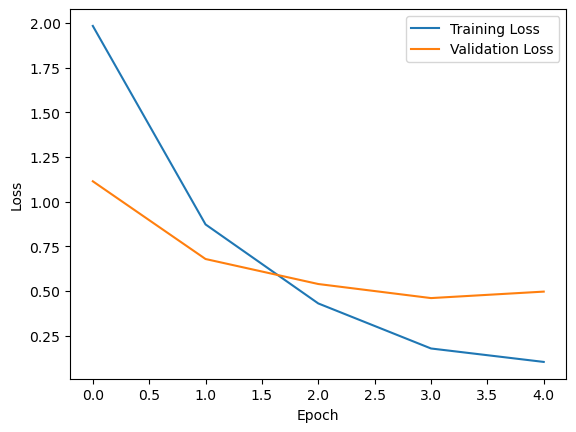

In [43]:
pyplt.plot(train_losses, label='Training Loss')
pyplt.plot(val_losses, label='Validation Loss')
pyplt.xlabel('Epoch')
pyplt.ylabel('Loss')
pyplt.legend()
pyplt.show()

### Perform sample inferences on random test images with different labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


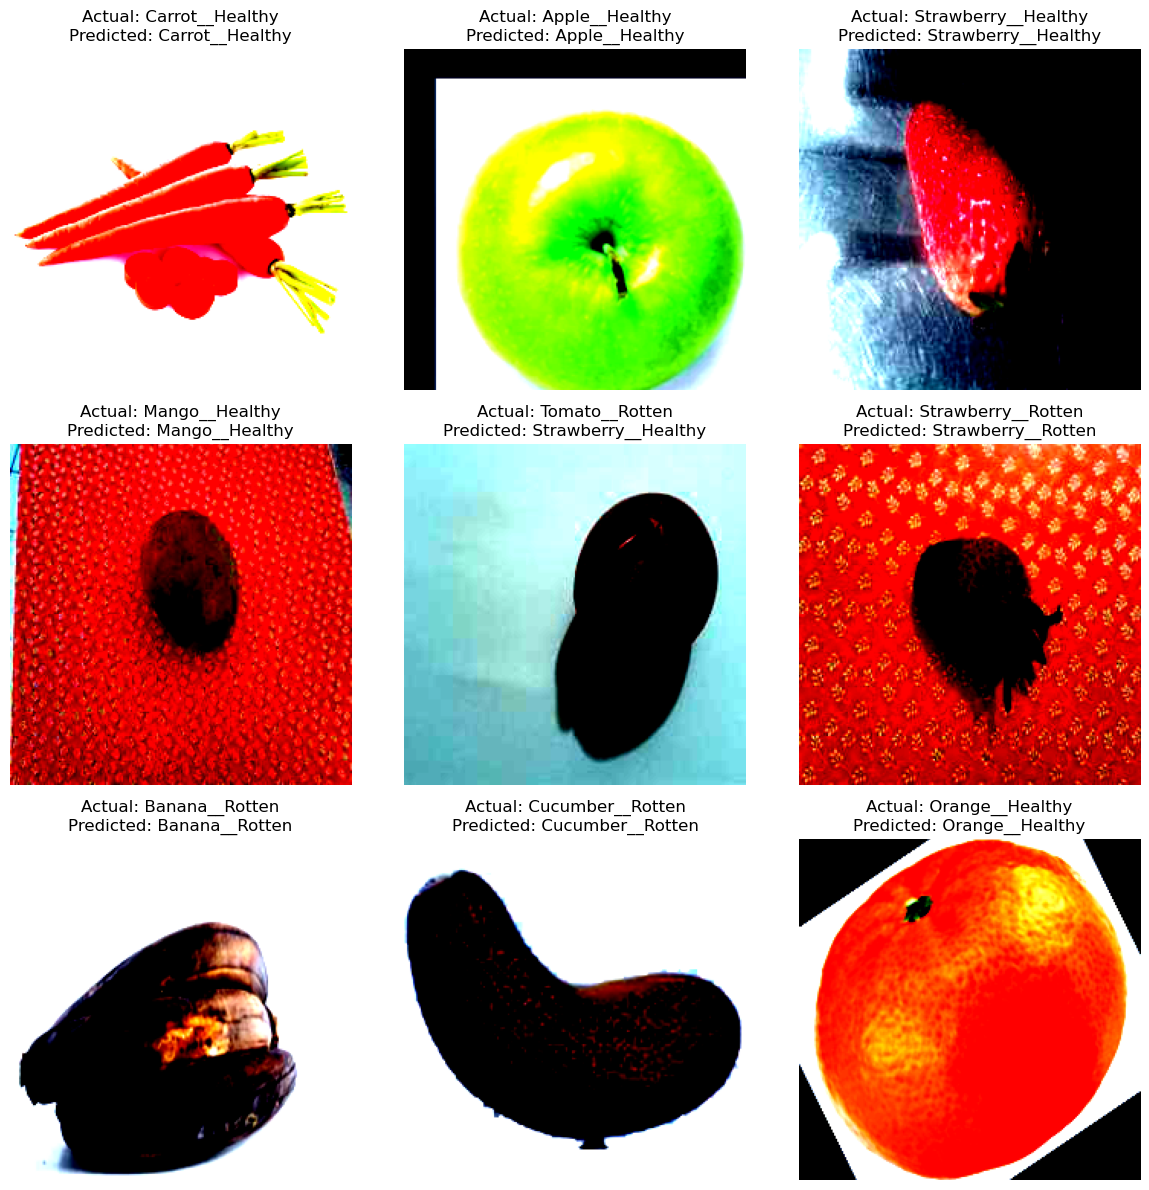

In [49]:
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    
    selected_images = []
    selected_labels = []
    selected_predicted = []
    
    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0)
        
        output = cnn_model(image.to(device)).to(device)
        _, predicted = torch.max(output, 1)
        
        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())
        
        if len(selected_labels) == 9:
            break
    
    fig, axes = pyplt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"Actual: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')
    
    pyplt.tight_layout()
    pyplt.show()

## Transfer Learning

### Spliting dataset in train,val & test Dataloader for pre-trained models like ResNet50 and EfficientNet V2

In [90]:
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Calculate split sizes
dataset_size = len(full_dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check sizes
print(f'Total dataset size: {dataset_size}')
print(f'Train dataset size: {train_size}')
print(f'Validation dataset size: {val_size}')
print(f'Test dataset size: {test_size}')


Total dataset size: 29291
Train dataset size: 17574
Validation dataset size: 5858
Test dataset size: 5859


# load pre-trained ResNet50 model

In [91]:
rn50_model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [92]:
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=28))

In [93]:
# freeze pre-trained layers
for param in rn50_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in rn50_model.fc.parameters():
    param.requires_grad = True

In [94]:
rn50_model = rn50_model.to(device)

In [95]:
optim_rn50 = optim.Adam(rn50_model.parameters(), lr=learning_rate)

# load pre-trained EfficientNet V2 model

In [96]:
ev2_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

In [97]:
ev2_model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=28))

In [98]:
# freeze pre-trained layers
for param in ev2_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in ev2_model.classifier.parameters():
    param.requires_grad = True

In [99]:
ev2_model = ev2_model.to(device)

In [100]:
optim_ev2 = optim.Adam(ev2_model.parameters(), lr=learning_rate)

### Train loop test for pre-trained models

In [101]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put model in train mode
    model.train()

    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # 6. calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


### Validation loop test for pre-trained models

In [102]:
def val_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module):
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # turn on inference context manager
    with torch.inference_mode():
        # loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            val_pred_logits = model(X)

            # 2. calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # 3. calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc


### Train loop function for pre-trained ResNet50 and EfficientNet V2 model

In [103]:
def train_process(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  val_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                  epochs: int = 5):

    # 2. create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # 3. loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn)

        # 4. print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.5f} | "
            f"train_acc: {train_acc:.5f} | "
            f"val_loss: {val_loss:.5f} | "
            f"val_acc: {val_acc:.5f}"
        )

        # 5. update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. return the filled results at the end of the epochs
    return results

## Fine tuning ResNet50 model

In [119]:
rn50_results = train_process(model=rn50_model,
                             train_dataloader=train_loader,
                             val_dataloader=val_loader,
                             optimizer=optim_rn50,
                             loss_fn=criterion,
                             epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.13922 | train_acc: 0.97191 | val_loss: 0.13248 | val_acc: 0.96705
Epoch: 2 | train_loss: 0.10078 | train_acc: 0.98176 | val_loss: 0.11287 | val_acc: 0.96960
Epoch: 3 | train_loss: 0.07890 | train_acc: 0.98500 | val_loss: 0.10157 | val_acc: 0.97435
Epoch: 4 | train_loss: 0.06246 | train_acc: 0.98960 | val_loss: 0.09291 | val_acc: 0.97435
Epoch: 5 | train_loss: 0.05415 | train_acc: 0.99089 | val_loss: 0.08943 | val_acc: 0.97656


## Fine tuning EfficientNet V2 model

In [109]:
ev2_results = train_process(model=ev2_model,
                             train_dataloader=train_loader,
                             val_dataloader=val_loader,
                             optimizer=optim_ev2,
                             loss_fn=criterion,
                             epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.80822 | train_acc: 0.81913 | val_loss: 0.39008 | val_acc: 0.90438
Epoch: 2 | train_loss: 0.34938 | train_acc: 0.90697 | val_loss: 0.28789 | val_acc: 0.92408
Epoch: 3 | train_loss: 0.27743 | train_acc: 0.92271 | val_loss: 0.25147 | val_acc: 0.92935
Epoch: 4 | train_loss: 0.23149 | train_acc: 0.93521 | val_loss: 0.21870 | val_acc: 0.93512
Epoch: 5 | train_loss: 0.21072 | train_acc: 0.94004 | val_loss: 0.21076 | val_acc: 0.93461


## Plotting loss and accuracy from ResNet50 model results

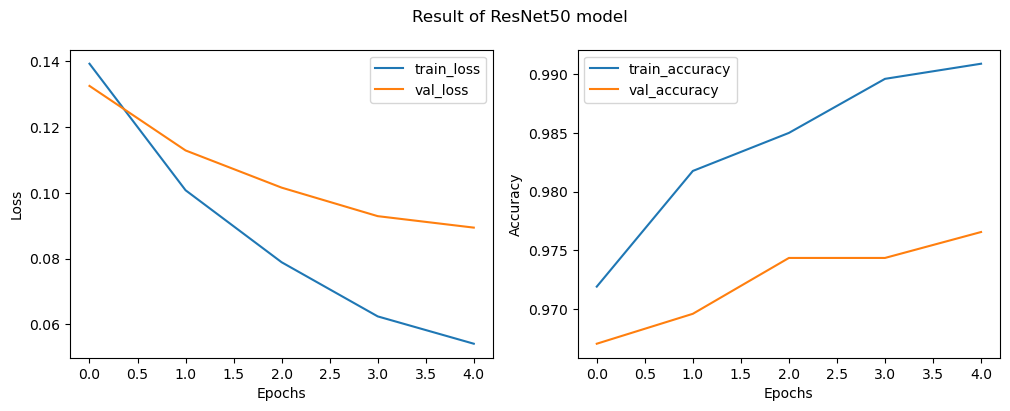

In [120]:
loss = rn50_results["train_loss"]
val_loss = rn50_results["val_loss"]


accuracy = rn50_results["train_acc"]
val_accuracy = rn50_results["val_acc"]


epochs = range(len(rn50_results["train_loss"]))


pyplt.figure(figsize=(12, 4))


pyplt.subplot(1, 2, 1)
pyplt.plot(epochs, loss, label="train_loss")
pyplt.plot(epochs, val_loss, label="val_loss")
pyplt.ylabel("Loss")
pyplt.xlabel("Epochs")
pyplt.legend()


pyplt.subplot(1, 2, 2)
pyplt.plot(epochs, accuracy, label="train_accuracy")
pyplt.plot(epochs, val_accuracy, label="val_accuracy")
pyplt.ylabel("Accuracy")
pyplt.xlabel("Epochs")
pyplt.legend()

pyplt.suptitle("Result of ResNet50 model")

pyplt.show()


## Plotting loss and accuracy from EfficientNet V2 model results

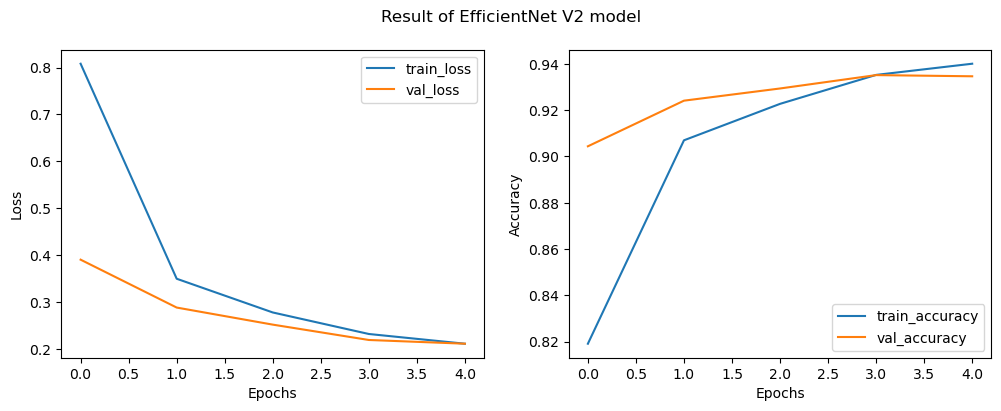

In [111]:
loss = ev2_results["train_loss"]
val_loss = ev2_results["val_loss"]


accuracy = ev2_results["train_acc"]
val_accuracy = ev2_results["val_acc"]


epochs = range(len(ev2_results["train_loss"]))


pyplt.figure(figsize=(12, 4))


pyplt.subplot(1, 2, 1)
pyplt.plot(epochs, loss, label="train_loss")
pyplt.plot(epochs, val_loss, label="val_loss")
pyplt.ylabel("Loss")
pyplt.xlabel("Epochs")
pyplt.legend()


pyplt.subplot(1, 2, 2)
pyplt.plot(epochs, accuracy, label="train_accuracy")
pyplt.plot(epochs, val_accuracy, label="val_accuracy")
pyplt.ylabel("Accuracy")
pyplt.xlabel("Epochs")
pyplt.legend()

pyplt.suptitle("Result of EfficientNet V2 model")

pyplt.show()
